# MNIST VAE Visualization

이 노트북은 학습된 MNIST VAE 모델을 시각화합니다:
1. 잠재 공간 시각화 (2D)
2. 재구성 결과
3. 잠재 공간에서 새로운 이미지 생성
4. 잠재 공간 보간 (Interpolation)

In [1]:
import os
import sys
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from hydra import initialize, compose
from omegaconf import OmegaConf
import logging

sys.path.append('..')
from src.models.mnist_vae import MnistVAE
from src.data.MNIST_data import MNISTDataModule

# 모델 이름 (Hydra 로그 디렉토리 구조)
MODEL_NAME = "mnist-vae"

In [2]:
# run_timestamp 설정 (None이면 가장 최근 실행 자동 선택)
run_timestamp = None  # 예: "2025-12-20/16-44-09"

# 가장 최근 실행 찾기
def find_latest_run(base_dir=f"../saved/hydra_logs/{MODEL_NAME}"):
    """가장 최근 실행 디렉토리 찾기"""
    pattern = os.path.join(base_dir, "*", "*")
    all_runs = glob.glob(pattern)
    
    if not all_runs:
        raise FileNotFoundError(f"No run directories found in {base_dir}")
    
    # 날짜/시간 기준으로 정렬
    all_runs.sort()
    latest_run = all_runs[-1]
    
    # 상대 경로로 변환
    run_timestamp = os.path.relpath(latest_run, base_dir)
    
    return run_timestamp

if run_timestamp is None:
    run_timestamp = find_latest_run()
    print(f"✅ Using latest run: {run_timestamp}")
else:
    print(f"✅ Using specified run: {run_timestamp}")

# Hydra 설정 로드
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="mnist_vae")

print("\n" + "="*80)
print("Configuration:")
print(OmegaConf.to_yaml(cfg))
print("="*80)

✅ Using latest run: 2025-12-20/17-54-10

Configuration:
tensorboard:
  save_dir: ./saved/tensorboard_logs
checkpoint:
  save_top_k: 1
  monitor: val_loss
  mode: min
seed: 42
float32_matmul_precision: medium
model_name: mnist-vae
data:
  data_dir: ~/data/
  batch_size: 128
  target_labels:
  - 0
  - 1
  - 2
  - 3
  - 4
  - 5
  - 6
  - 7
  - 8
  - 9
model:
  input_dim: 784
  hidden_dims:
  - 256
  - 128
  latent_dim: 2
  kl_weight: 1.0
training:
  max_epochs: 50
  lr: 0.001
  weight_decay: 0.1
  T_max: 100
trainer:
  devices: auto
  log_every_n_steps: 10
  val_check_interval: 1.0
  enable_progress_bar: true
  enable_model_summary: true



In [3]:
# 체크포인트 로드 (Hydra 실행 디렉토리 기준)
checkpoint_dir = os.path.join('..', 'saved', 'hydra_logs', MODEL_NAME, run_timestamp, 'checkpoints')

if not os.path.exists(checkpoint_dir):
    raise FileNotFoundError(f"Checkpoint directory not found: {checkpoint_dir}")

# 체크포인트 파일 찾기
checkpoints = glob.glob(os.path.join(checkpoint_dir, "mnist-vae-*.ckpt"))

if not checkpoints:
    raise FileNotFoundError(f"No checkpoints found in {checkpoint_dir}")

# 가장 좋은 체크포인트 선택 (val_loss 기준)
def extract_val_loss(ckpt_path):
    filename = os.path.basename(ckpt_path)
    try:
        loss_str = filename.split("val_loss=")[1].split(".ckpt")[0]
        return float(loss_str)
    except:
        return float('inf')

best_checkpoint = min(checkpoints, key=extract_val_loss)
print(f"✅ Loading checkpoint: {best_checkpoint}")

✅ Loading checkpoint: ../saved/hydra_logs/mnist-vae/2025-12-20/17-54-10/checkpoints/mnist-vae-epoch=48-val_loss=140.23.ckpt


In [4]:
# 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PyTorch 2.6+ 호환성: weights_only=False 설정
vae = MnistVAE.load_from_checkpoint(best_checkpoint, weights_only=False)
vae.to(device)
vae.eval()
print(f"✅ Model loaded on {device}")
print(f"Hyperparameters: {vae.hparams}")

✅ Model loaded on cuda
Hyperparameters: "hidden_dims":  [256, 128]
"input_dim":    784
"kl_weight":    1.0
"latent_dim":   2
"lr":           0.001
"weight_decay": 0.1


In [5]:
# 데이터 로드
mnist = MNISTDataModule(
    data_dir=cfg.data.data_dir,
    batch_size=cfg.data.batch_size,
    target_labels=cfg.data.target_labels,
)
mnist.setup("test")
test_loader = mnist.test_dataloader()
print(f"Test dataset size: {len(mnist.mnist_test)}")

Test dataset size: 10000


## 1. 잠재 공간 시각화 (2D Latent Space)

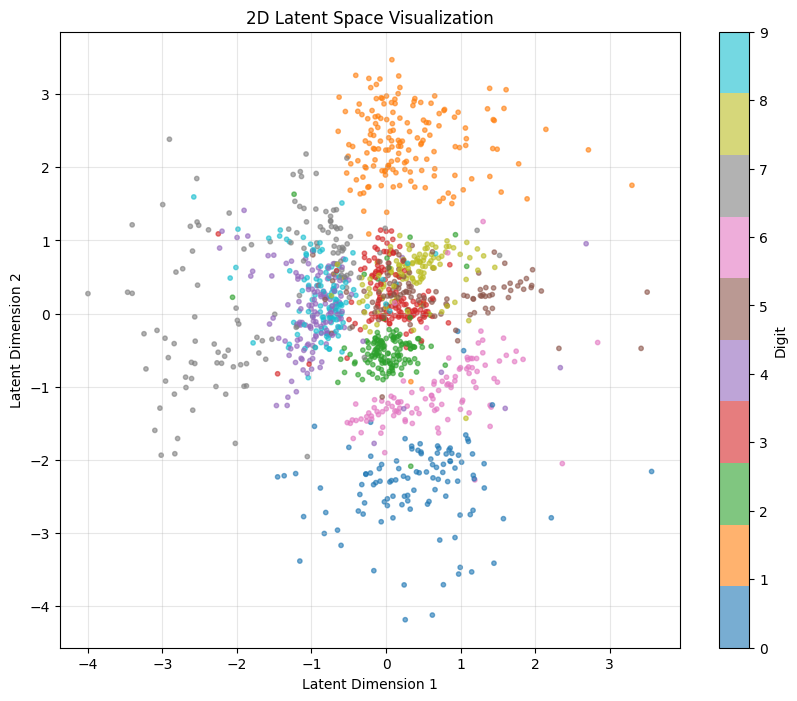

In [6]:
def visualize_latent_space(model, data_loader, device, num_batches=10):
    """
    잠재 공간을 2D 산점도로 시각화
    """
    model.eval()
    latents = []
    labels = []
    
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            if i >= num_batches:
                break
            
            x = x.view(x.size(0), -1).to(device)
            mu, _ = model.encode(x)
            
            latents.append(mu.cpu().numpy())
            labels.append(y.numpy())
    
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    # 시각화
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Digit')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space Visualization')
    plt.grid(True, alpha=0.3)
    plt.show()

visualize_latent_space(vae, test_loader, device)

## 2. 재구성 결과 시각화

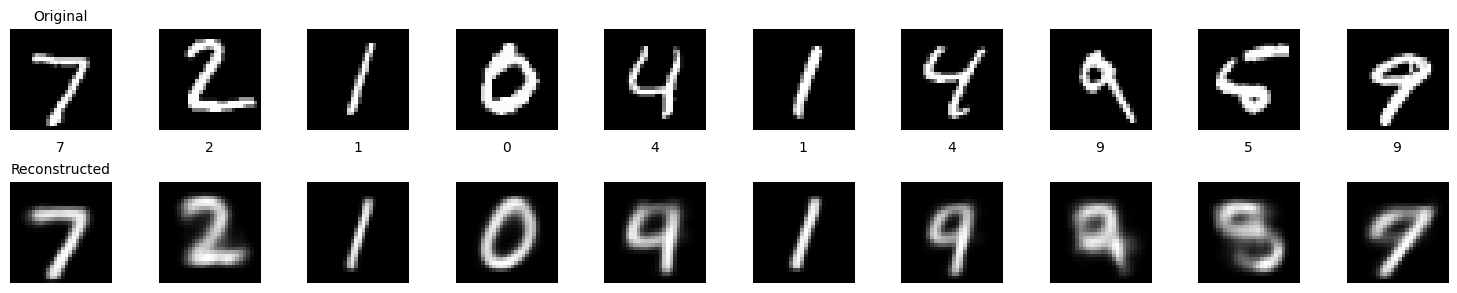

In [7]:
def visualize_reconstruction(model, data_loader, device, num_samples=10):
    """
    원본 이미지와 재구성된 이미지 비교
    """
    model.eval()
    
    # 샘플 가져오기
    x, y = next(iter(data_loader))
    x = x[:num_samples].to(device)
    y = y[:num_samples]
    
    with torch.no_grad():
        x_flat = x.view(x.size(0), -1)
        x_hat, _, _ = model(x_flat)
        x_hat = x_hat.view(-1, 1, 28, 28)
    
    # 시각화
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 1.5, 3))
    
    for i in range(num_samples):
        # 원본
        axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        # 재구성
        axes[1, i].imshow(x_hat[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)
        
        axes[0, i].text(0.5, -0.1, f'{y[i].item()}', 
                       ha='center', va='top', transform=axes[0, i].transAxes)
    
    plt.tight_layout()
    plt.show()

visualize_reconstruction(vae, test_loader, device)

## 3. 잠재 공간에서 새로운 이미지 생성

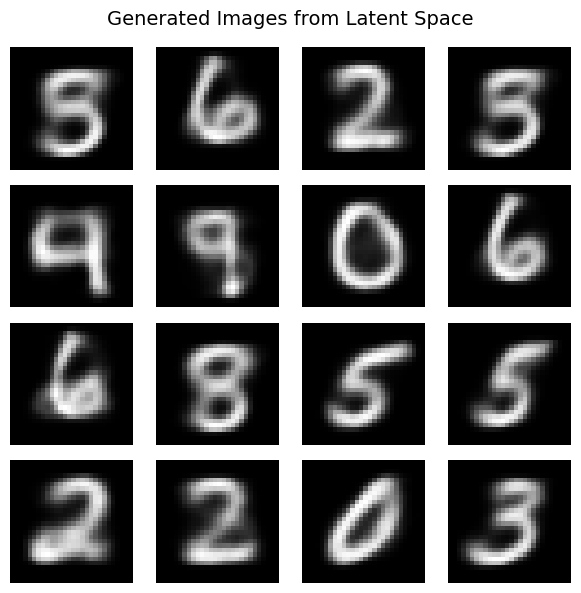

In [8]:
def visualize_generation(model, num_samples=16):
    """
    잠재 공간에서 랜덤 샘플링하여 새로운 이미지 생성
    """
    generated = model.sample(num_samples)
    generated = generated.view(-1, 1, 28, 28).cpu()
    
    # 시각화
    n_rows = 4
    n_cols = num_samples // n_rows
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
    
    for i in range(num_samples):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].imshow(generated[i].squeeze(), cmap='gray')
        axes[row, col].axis('off')
    
    plt.suptitle('Generated Images from Latent Space', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_generation(vae)

## 4. 잠재 공간 보간 (Latent Space Interpolation)

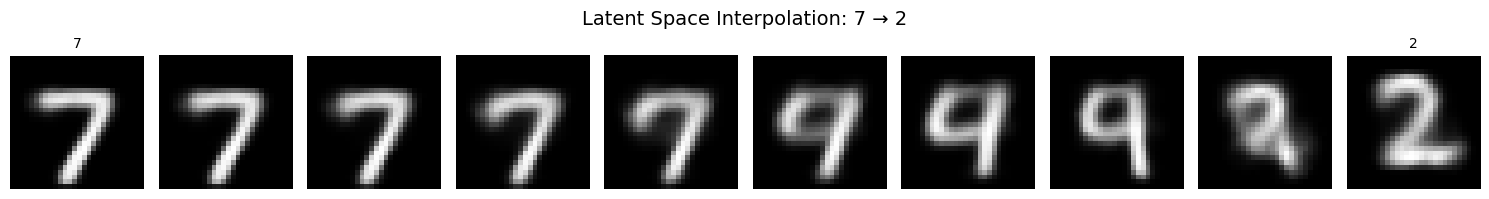

In [9]:
def visualize_interpolation(model, data_loader, device, num_steps=10):
    """
    두 이미지 사이의 잠재 공간 보간
    """
    model.eval()
    
    # 두 개의 샘플 가져오기
    x, y = next(iter(data_loader))
    x1, x2 = x[0:1].to(device), x[1:2].to(device)
    y1, y2 = y[0].item(), y[1].item()
    
    with torch.no_grad():
        x1_flat = x1.view(1, -1)
        x2_flat = x2.view(1, -1)
        
        # 잠재 벡터 추출
        z1, _ = model.encode(x1_flat)
        z2, _ = model.encode(x2_flat)
        
        # 보간
        alphas = np.linspace(0, 1, num_steps)
        interpolated_images = []
        
        for alpha in alphas:
            z_interp = (1 - alpha) * z1 + alpha * z2
            x_interp = model.decode(z_interp)
            interpolated_images.append(x_interp.view(28, 28).cpu())
    
    # 시각화
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 1.5, 2))
    
    for i, img in enumerate(interpolated_images):
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        if i == 0:
            axes[i].set_title(f'{y1}', fontsize=10)
        elif i == num_steps - 1:
            axes[i].set_title(f'{y2}', fontsize=10)
    
    plt.suptitle(f'Latent Space Interpolation: {y1} → {y2}', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_interpolation(vae, test_loader, device)

## 5. 잠재 공간 Grid 시각화

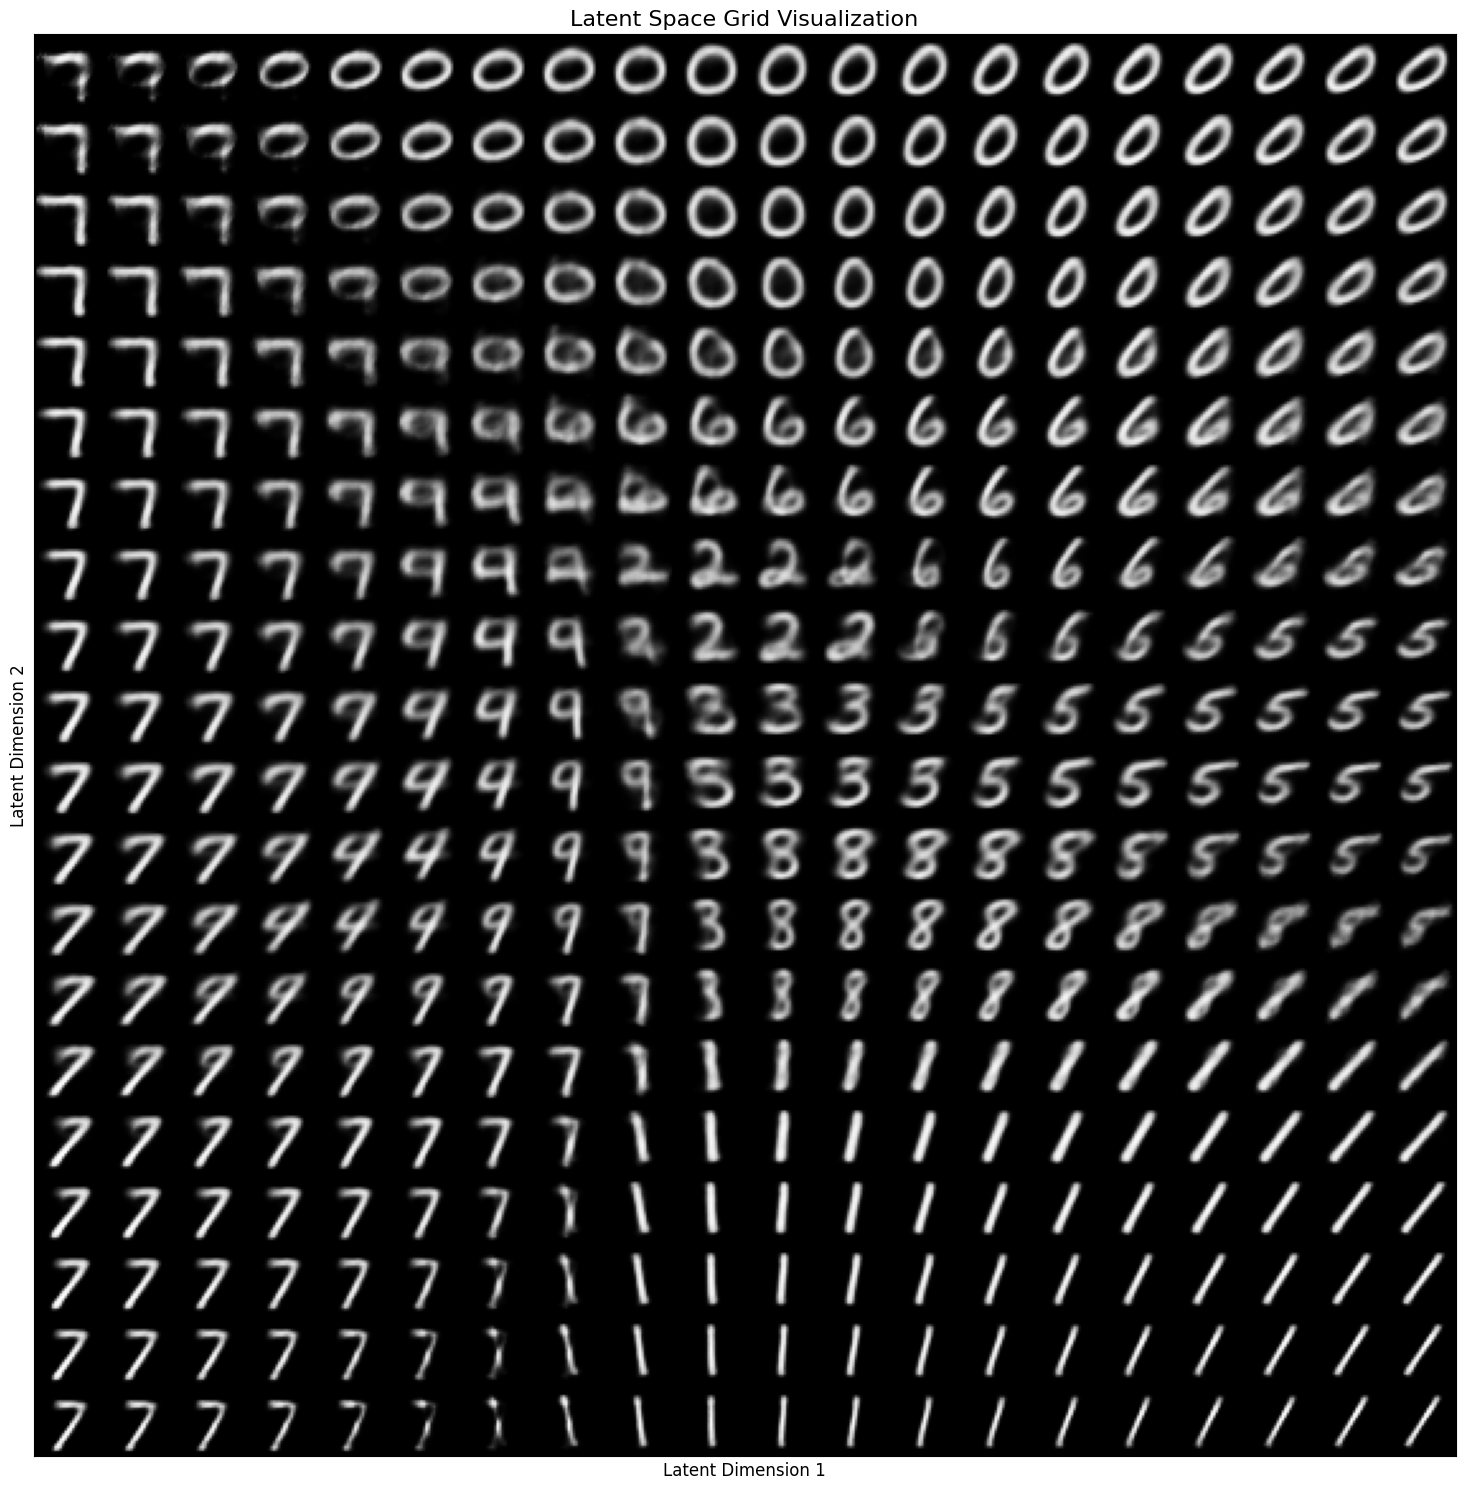

In [10]:
def visualize_latent_grid(model, n=20, range_val=3):
    """
    잠재 공간을 균등하게 샘플링하여 그리드로 시각화
    """
    model.eval()
    
    # 그리드 생성
    grid_x = np.linspace(-range_val, range_val, n)
    grid_y = np.linspace(-range_val, range_val, n)
    
    figure = np.zeros((28 * n, 28 * n))
    
    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
                x_hat = model.decode(z)
                digit = x_hat.view(28, 28).cpu().numpy()
                figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit
    
    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap='gray')
    plt.title('Latent Space Grid Visualization', fontsize=16)
    plt.xlabel('Latent Dimension 1', fontsize=12)
    plt.ylabel('Latent Dimension 2', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

visualize_latent_grid(vae)